# Spark Metastore

Let us understand how to interact with metastore tables using Spark based APIs.

## Overview of Spark Metastore

Let us get an overview of Spark Metastore and how we can leverage it to manage databases and tables on top of Big Data based file systems such as HDFS, s3 etc.

* Quite often we need to deal with structured data and the most popular way of processing structured data is by using Databases, Tables and then SQL.
* Spark Metastore (similar to Hive Metastore) will facilitate us to manage databases and tables.
* Typically Metastore is setup using traditional relational database technologies such as **Oracle**, **MySQL**, **Postgres** etc.

## Starting Spark Context

Let us start spark context for this Notebook so that we can execute the code provided.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession. \
    builder. \
    config('spark.ui.port', '0'). \
    appName('Spark Metastore'). \
    master('yarn'). \
    getOrCreate()

In [ ]:
spark.conf.set('spark.sql.shuffle.partitions', '2')

## Spark Catalog

Let us get an overview of Spark Catalog. It is part of `SparkSession` object.
* We can permanently or temporarily create tables or views on top of data in a Data Frame.
* Metadata such as table names, column names, data types etc for these tables or views will be stored in Metastore. It is also known as catalog which is exposed as part of SparkSession object.
* Permanent tables can be grouped into databases in metastore. If not specified, the tables will be created in **default** database.
* Let us say `spark` is of type `SparkSession`. There is an attribute as part of `spark` called as catalog and it is of type pyspark.sql.catalog.Catalog.
* We can access catalog using `spark.catalog`.
* There are several methods that is part of `spark.catalog`. We will explore them in the later topics.
* Following are some of the tasks that can be performed using `spark.catalog` object.
 * Check current database and switch to different databases.
 * Create permanent table in metastore.
 * Create or drop temporary views.
 * Register functions.
* All the above tasks can be performed using SQL style commands passed to `spark.sql`.

## Creating Metastore Tables

Data Frames can be written into Metastore Tables using APIs such as `saveAsTable` and `insertInto` available as part of write on top of objects of type Data Frame.

* We can create a new table using Data Frame using `saveAsTable`. We can also create an empty table by using `spark.catalog.createTable` or `spark.catalog.createExternalTable`.
* We can also prefix the database name to write data into tables belong to a particular database. If the database is not specified then the session will be attached to default database.
* Databases can be created using `spark.sql("CREATE DATABASE database_name")`. We can list Databases using `spark.sql` or `spark.catalog.listDatabases()`
* We can use modes such as `append`, `overwrite` and `error` with `saveAsTable`. Default is error.
* We can use modes such as `append` and `overwrite` with `insertInto`. Default is append.
* When we use `saveAsTable`, following happens:
 * Check for table if the table already exists. By default `saveAsTable` will throw exception.
 * If the table does not exists the table will be created.
 * Data from Data Frame will be copied into the table.
 * We can alter the behavior by using mode. We can overwrite the existing table or we can append into it.
* We can list the tables using `spark.catalog.listTables` after switching to appropriate database using `spark.catalog.setCurrentDatabase`.
* We can also switch the database and list tables using `spark.sql`.

In [ ]:
spark.catalog?

### Tasks
Let us perform few tasks to understand how to write a Data Frame into Metastore tables and also list them.
* Create database by name db in the metastore. We need to use `spark.sql` as there is no function to create database under `spark.catalog`.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f"CREATE DATABASE {username}_db")

In [ ]:
spark.catalog.setCurrentDatabase(f'{username}_db')

* List the databases using both API as well as SQL approach. As we have too many databases in our environment, it might take too much time to return the results

In [ ]:
spark.catalog.listDatabases()

* Create a Data Frame which contain one column by name **dummy** and one row with value **X**.

In [ ]:
l = [("X", )]
df = spark.createDataFrame(l, schema="dummy STRING")

In [ ]:
spark.catalog.listTables()

* Create a table by name dual for the above Data Frame in the database created. 

In [ ]:
df.write.saveAsTable("dual")

In [ ]:
spark.catalog.listTables()

In [ ]:
spark.read.table("dual").show()

* Let us drop the table **dual** and then database **db**. We need to use `spark.sql` as `spark.catalog` does not have API to drop the tables or databases.

In [ ]:
spark.sql("DROP TABLE dual")

In [ ]:
spark.sql(f"DROP DATABASE {username}_db")

In [ ]:
# We can use CASCADE to drop database along with tables.
spark.sql(f"DROP DATABASE {username}_db CASCADE")

## Define Schema for Tables

When we want to create a table using `spark.catalog.createTable` or using `spark.catalog.createExternalTable`, we need to specify Schema.

* Schema can be inferred or we can pass schema using `StructType` object while creating the table..
* `StructType` takes list of objects of type `StructField`.
* `StructField` is built using column name and data type. All the data types are available under `pyspark.sql.types`.
* We need to pass table name and schema for `spark.catalog.createTable`.
* We have to pass path along with name and schema for `spark.catalog.createExternalTable`.
* We can use source to define file format along with applicable options. For example, if we want to create a table for CSV, then source will be csv and we can pass applicable options for CSV such as sep, header etc.

### Tasks

Let us perform tasks to create empty table using `spark.catalog.createTable` or using `spark.catalog.createExternalTable`.

* Create database **hr_db** and table **employees** with following fields. Let us create Database first and then we will see how to create table.
 * employee_id of type Integer
 * first_name of type String
 * last_name of type String
 * salary of type Float
 * nationality of type String

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS {username}_hr_db")

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_hr_db")

In [ ]:
spark.catalog.createTable?

* Build StructType object using StructField list.

In [ ]:
from pyspark.sql.types import StructField, StructType, \
    IntegerType, StringType, FloatType

In [ ]:
employeesSchema = StructType([
    StructField("employee_id", IntegerType()),
    StructField("first_name", StringType()),
    StructField("last_name", StringType()),
    StructField("salary", FloatType()),
    StructField("nationality", StringType())
])

In [ ]:
spark.sql('DROP TABLE employees')

* Create table by passing StructType object as schema.

In [ ]:
spark.catalog.createTable("employees", schema=employeesSchema)

* List the tables from database created.

In [ ]:
spark.catalog.listTables()

In [ ]:
spark.catalog.listColumns('employees')

In [ ]:
spark.sql('DESCRIBE FORMATTED employees').show(100, truncate=False)

* Create database by name **{username}_airlines** and create external table for **airport-codes.txt**.
 * Data have header
 * Fields in each record are delimited by a tab character.
 * We can pass options such as sep, header, inferSchema etc to define the schema.


In [ ]:
spark.catalog.createExternalTable?

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS {username}_airlines")

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

* To create external table, we need to have write permissions over the path which we want to use.
* As we have only read permissions on **/public/airlines_all/airport-codes** we cannot use that path while creating external table.
* Let us copy the data to **/user/`whoami`/airlines_all/airport-codes**

In [ ]:
%%sh

hdfs dfs -mkdir -p /user/`whoami`/airlines_all
hdfs dfs -cp -f /public/airlines_all/airport-codes /user/`whoami`/airlines_all
hdfs dfs -ls /user/`whoami`/airlines_all/airport-codes

In [ ]:
%%sh

hdfs dfs -tail /user/`whoami`/airlines_all/airport-codes/airport-codes-na.txt

In [ ]:
import getpass
username = getpass.getuser()

airport_codes_path = f'/user/{username}/airlines_all/airport-codes'

In [ ]:
spark.sql('DROP TABLE airport_codes')

In [ ]:
spark.catalog. \
    createExternalTable("airport_codes",
                        path=airport_codes_path,
                        source="csv",
                        sep="\t",
                        header="true",
                        inferSchema="true"
                       )

In [ ]:
spark.catalog.listTables()

In [ ]:
spark.read.table("airport_codes").show()

In [ ]:
spark.sql('DESCRIBE FORMATTED airport_codes').show(100, False)

## Inserting into Existing Tables

Let us understand how we can insert data into existing tables using `insertInto`.

* We can use modes such as `append` and `overwrite` with `insertInto`. Default is `append`.
* When we use `insertInto`, following happens:
 * If the table does not exist, `insertInto` will throw an exception.
 * If the table exists, by default data will be appended.
 * We can alter the behavior by using keyword argument overwrite. It is by default False, we can pass True to replace existing data.

### Tasks

Let us perform few tasks to understand how to write a Data Frame into existing tables in the Metastore.

* Make sure hr_db database and employees table in hr_db are created.

In [ ]:
spark.catalog.listDatabases()

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_hr_db")

In [ ]:
spark.catalog.listTables()

Use employees Data Frame and insert data into the employees table in hr_db database. Make sure existing data is overwritten.

In [ ]:
employees = [(1, "Scott", "Tiger", 1000.0, "united states"),
             (2, "Henry", "Ford", 1250.0, "India"),
             (3, "Nick", "Junior", 750.0, "united KINGDOM"),
             (4, "Bill", "Gomes", 1500.0, "AUSTRALIA")
            ]

In [ ]:
employeesDF = spark.createDataFrame(employees,
    schema="""employee_id INT, first_name STRING, last_name STRING,
              salary FLOAT, nationality STRING
           """
)

In [ ]:
employeesDF.write.insertInto("employees", overwrite=True)

In [ ]:
employeesDF.write.mode('overwrite').insertInto("employees")

In [ ]:
spark.read.table("employees").show()

## Reading and Processing Tables

Let us see how we can read tables using functions such as `spark.read.table` and process data using Data Frame APIs.

* Using Data Frame APIs - `spark.read.table("table_name")`.
* We can also prefix the database name to read tables belong to a particular database.
* When we read the table, it will result in a Data Frame.
* Once Data Frame is created we can use functions such as `filter` or `where`, `groupBy`, `sort` or `orderBy` to process the data in the Data Frame.

### Tasks
Let us see how we can create a table using data in a file and then read into a Data Frame.

* Create Database for **airlines** data.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS {username}_airlines")

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

* Create table by name **airport-codes** for file **airport-codes.txt**. The file contains header and each field in each row is delimited by a tab character.

In [ ]:
airport_codes_path = f"/user/{username}/airlines_all/airport-codes"

In [ ]:
spark.sql(f'DROP TABLE {username}_airlines.airport_codes')

In [ ]:
airport_codes_df = spark. \
    read. \
    csv(airport_codes_path,
        sep="\t",
        header=True,
        inferSchema=True
       )

In [ ]:
airport_codes_df.write.saveAsTable(f"{username}_airlines.airport_codes")

* Read data from table and get number of airports by state.

In [ ]:
airport_codes = spark.read.table("airport_codes")

In [ ]:
type(airport_codes)

In [ ]:
spark.sql('DESCRIBE FORMATTED airport_codes').show(100, False)

In [ ]:
airport_codes. \
    groupBy("state"). \
    count(). \
    show()

## Creating Partitioned Tables

We can also create partitioned tables as part of Spark Metastore Tables.

* There are some challenges in creating partitioned tables directly using `spark.catalog.createTable`.
* But if the directories are similar to partitioned tables with data, we should be able to create partitioned tables. They are typically external tables.
* Let us create partitioned table for `orders` by `order_month`.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f'CREATE DATABASE IF NOT EXISTS {username}_retail')

In [ ]:
spark.catalog.setCurrentDatabase(f'{username}_retail')

In [ ]:
orders_path = '/public/retail_db/orders'

In [ ]:
%%sh

hdfs dfs -ls /public/retail_db/orders

In [ ]:
from pyspark.sql.functions import date_format

In [ ]:
spark.sql('DROP TABLE orders_part')

In [ ]:
%%sh

hdfs dfs -ls /user/`whoami`/retail_db/orders_part

In [ ]:
%%sh

hdfs dfs -rm -R /user/`whoami`/retail_db/orders_part

In [ ]:
spark. \
    read. \
    csv(orders_path,
        schema='''order_id INT, order_date DATE,
                  order_customer_id INT, order_status STRING
               '''
       ). \
    withColumn('order_month', date_format('order_date', 'yyyyMM')). \
    write. \
    partitionBy('order_month'). \
    parquet(f'/user/{username}/retail_db/orders_part')

In [ ]:
%%sh

hdfs dfs -ls -R /user/`whoami`/retail_db/orders_part

In [ ]:
spark. \
    read. \
    parquet(f'/user/{username}/retail_db/orders_part/order_month=201308'). \
    show()

In [ ]:
spark. \
    read. \
    parquet(f'/user/{username}/retail_db/orders_part'). \
    show()

In [ ]:
spark. \
    catalog. \
    createTable('orders_part',
                path=f'/user/{username}/retail_db/orders_part',
                source='parquet'
               )

In [ ]:
spark.catalog.recoverPartitions('orders_part')

In [ ]:
spark.read.table('orders_part').show()

In [ ]:
spark.sql('SELECT order_month, count(1) FROM orders_part GROUP BY order_month').show()

## Creating Temp Views

So far we spoke about permanent metastore tables. Now let us understand how to create temporary views using a Data Frame.

* We can create temporary view for a Data Frame using `createTempView` or `createOrReplaceTempView`.
* `createOrReplaceTempView` will replace existing view, if it already exists.
* While tables in Metastore are permanent, views are temporary.
* Once the application exits, temporary views will be deleted or flushed out.

### Tasks

Let us perform few tasks to create temporary view and process the data using the temporary view.

* Create temporary view by name **airport_codes_v** for file **airport-codes.txt**. The file contains header and each field in each row is delimited by a tab character.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

In [ ]:
spark.catalog.listTables()

In [ ]:
airport_codes_path = f"/public/airlines_all/airport-codes"

In [ ]:
airport_codes_df = spark. \
    read. \
    csv(airport_codes_path,
        sep="\t",
        header=True,
        inferSchema=True
       )

In [ ]:
airport_codes_df.createTempView("airport_codes_v")

In [ ]:
spark.catalog.listTables()

* Read data from view and get number of airports by state.

In [ ]:
airport_codes = spark.read.table("airport_codes_v")

In [ ]:
airport_codes. \
    groupBy("state"). \
    count(). \
    show()

* List the tables in the metastore and views.

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

In [ ]:
spark.catalog.listTables()

## Using Spark SQL

Let us understand how we can use Spark SQL to process data in Metastore Tables and Temporary Views.

* Once tables are created in metastore or temporary views are created, we can run queries against the tables to perform all standard transformations.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

* Here are some of the transformations which can be performed.
 * Row Level Transformations using functions in SELECT clause.
 * Filtering using WHERE clause
 * Aggregations using GROUP BY and aggregate functions.
 * Sorting using ORDER BY or SORT BY

### Tasks

Let us perform some tasks to understand how to process data using Spark SQL using Metastore Tables or Temporary Views.
* Make sure table or view created for airport-codes. We can use the table or view created in the previous step.

In [ ]:
spark.catalog.listTables()

* Write a query to get number of airports per state in the US. 
 * Get only those states which have more than 10 airports.
 * Make sure data is sorted in descending order by number of airports.

In [101]:
spark. \
    sql("""SELECT state, count(1) AS airport_cnt
           FROM airport_codes_v
           GROUP BY state
               HAVING count(1) >= 10
           ORDER BY airport_cnt DESC
        """). \
  show()

+-----+-----------+
|state|airport_cnt|
+-----+-----------+
|   CA|         29|
|   TX|         26|
|   AK|         25|
|   BC|         22|
|   NY|         18|
|   ON|         18|
|   MI|         18|
|   FL|         18|
|   MT|         14|
|   PQ|         13|
|   PA|         13|
|   CO|         12|
|   IL|         12|
|   NC|         10|
|   WY|         10|
+-----+-----------+



In [102]:
airport_count = spark. \
    sql("""SELECT state, count(1) AS airport_cnt
           FROM airport_codes_v
           GROUP BY state
               HAVING count(1) >= 10
        """)

In [121]:
from matplotlib import pyplot as plt

airport_count_dict = dict(airport_count.collect())

In [130]:
states = list(airport_count_dict.keys())
states

['BC',
 'NY',
 'MI',
 'NC',
 'IL',
 'ON',
 'TX',
 'CO',
 'PA',
 'AK',
 'PQ',
 'CA',
 'MT',
 'WY',
 'FL']

In [132]:
airport_counts = list(airport_count_dict.values())
airport_counts

[22, 18, 18, 10, 12, 18, 26, 12, 13, 25, 13, 29, 14, 10, 18]

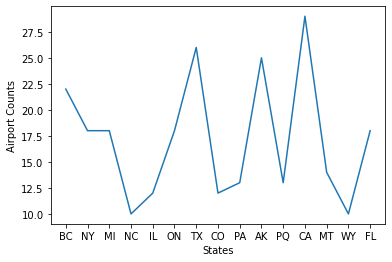

In [134]:
plt.plot(states, airport_counts)
plt.xlabel('States')
plt.ylabel('Airport Counts')
plt.show()